
# ML model to support approve/deny decision for credit card loan

#### sensitive variable: gender (other examples are race, and ethnicity)
#### fairness metrics: demographic parity, equal opportunity, and equal accuracy 

References:
- https://www.kaggle.com/code/alexisbcook/exercise-ai-fairness


# import

In [1]:
import pandas as pd
import numpy as np
import mlflow
import logging
import joblib, datetime, os, time, yaml
from os import environ as env
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import json
import base64
import os


# configure

In [2]:

config_file_path = 'config.yml'
model_name = 'Decision Tree'

In [3]:
# set logging
logging.basicConfig(level=logging.INFO, format="%(asctime)-15s %(message)s")
logger = logging.getLogger()

In [4]:
# set parameters
with open(config_file_path, "r") as file:
    config = yaml.safe_load(file)

# set model related parameters
data_file_path = config['data']['load_file_path']
selected_model_file_path = config['model']['save_file_path']
selected_model_metrics_file_path = config['model']['save_metrics_file_path']

# set MLFlow related parameters
experiment_name = config["mlflow"]["experiment_name"]
run_name = config["mlflow"]["run_name"]

# experiment

In [5]:
# load data

data = pd.read_csv(data_file_path)
X = data.drop(["Target"], axis=1)
y = data["Target"]

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)

print("Data successfully loaded!\n")
X_train.head()

Data successfully loaded!



,Num_Children,Group,Income,Own_Car,Own_Housing
288363,1,1,40690,0,1
64982,2,0,75469,1,0
227641,1,1,70497,1,1
137672,1,1,61000,0,0
12758,1,1,56666,1,1


In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd

# Confusion matrix with saving plot functionality
def get_confusion_matrix(estimator, X, y_true, y_pred, display_labels=["Deny", "Approve"],
                         include_values=True, xticks_rotation='horizontal', values_format='',
                         normalize=None, cmap=plt.cm.Blues, file_prefix=''):
    matrix = confusion_matrix(y_true, y_pred, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=display_labels)
    disp.plot(include_values=include_values, cmap=cmap, xticks_rotation=xticks_rotation, values_format=values_format)
    plt.savefig(f"{file_prefix}confusion_matrix.jpg",  bbox_inches='tight')  # Save plot as JPEG file
    return matrix, disp

# Fairness stats with saving plot functionality
def get_fairness_stats(X, y, model, group_one, preds):
    fairness_stats = {}
        
    y_zero, preds_zero, X_zero = y[group_one==False], preds[group_one==False], X[group_one==False]
    y_one, preds_one, X_one = y[group_one], preds[group_one], X[group_one]
    
    # Overall confusion matrix
    cm, disp = get_confusion_matrix(model, X, y, preds, file_prefix='overall_')
    disp.ax_.set_title("Overall")
    
    # Group 0 confusion matrix
    cm_zero, disp_zero = get_confusion_matrix(model, X_zero, y_zero, preds_zero, file_prefix='group_0_')
    disp_zero.ax_.set_title("Group 0")
    
    # Group 1 confusion matrix
    cm_one, disp_one = get_confusion_matrix(model, X_one, y_one, preds_one, file_prefix='group_1_')
    disp_one.ax_.set_title("Group 1")
    
    fairness_stats['demographic_parity'] = {'total_number_of_approvals': preds.sum(), 
                                            'group_0_%': round(preds_zero.sum()/sum(preds)*100, 2),
                                            'group_1_%': round(preds_one.sum()/sum(preds)*100, 2)}         
    fairness_stats['equal_opportunity'] = {'true_positive_rate': round(cm[1,1] / cm[1].sum()*100, 2),
                                           'group_0_%': round(cm_zero[1,1] / cm_zero[1].sum()*100, 2),
                                           'group_1_%': round(cm_one[1,1] / cm_one[1].sum()*100, 2)}
    fairness_stats['equal_accuracy'] = {'overall_accuracy': round((preds==y).sum()/len(y)*100, 2),
                                        'group_0_%': round((preds_zero==y_zero).sum()/len(y_zero)*100, 2),
                                        'group_1_%': round((preds_one==y_one).sum()/len(y_one)*100, 2)}
    fairness_stats['confusion_matrix'] = {'overall_confusion_matrix': cm.tolist(), 
                                          'group_0': cm_zero.tolist(),
                                          'group_1': cm_one.tolist()}
    return fairness_stats

# General metrics function
def get_metrics(y_true, y_pred):
    metrics = {}
    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred).tolist()
    metrics['precision'] = precision_score(y_true, y_pred)
    metrics['recall'] = recall_score(y_true, y_pred)
    metrics['f1'] = f1_score(y_true, y_pred)
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    return metrics

# Feature importance with saving plot functionality
def get_feature_importances(X, y):
    feature_names = X.columns
    forest = RandomForestClassifier(n_estimators= 120,min_samples_split = 3,  random_state=0)
    forest.fit(X, y)

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using Mean Decrease in Impurity")
    ax.set_ylabel("Mean decrease in impurity")
    plt.savefig("feature_importances.jpg",  bbox_inches='tight')  # Save plot as JPEG file
    return forest_importances.to_json()
    


In [7]:
# baseline model

# train
model_baseline = DecisionTreeClassifier(random_state=0, max_depth=3)
model_baseline.fit(X_train, y_train)

# predict
y_train_pred = model_baseline.predict(X_train)
y_test_pred = model_baseline.predict(X_test)

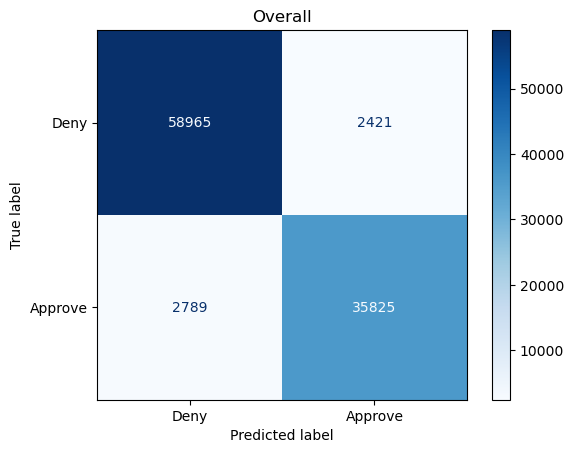

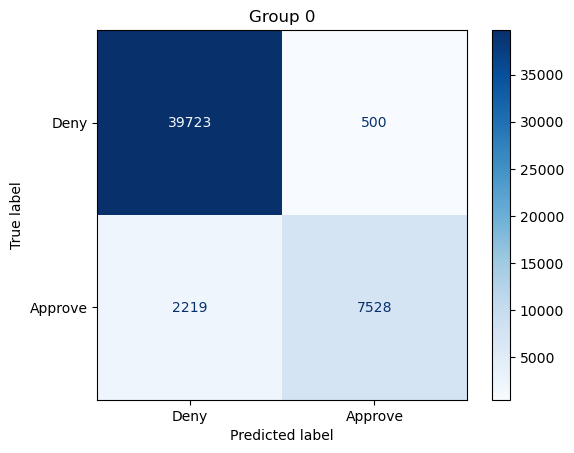

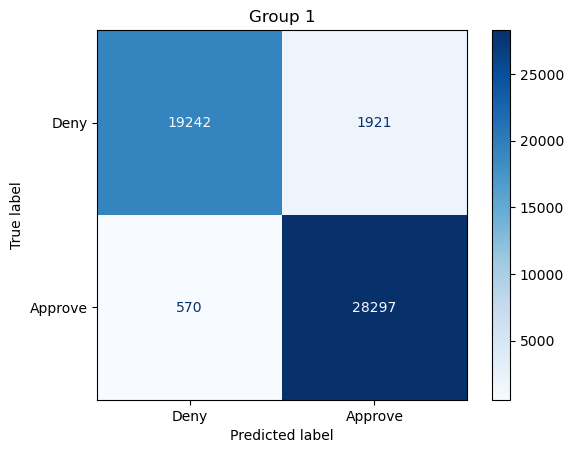

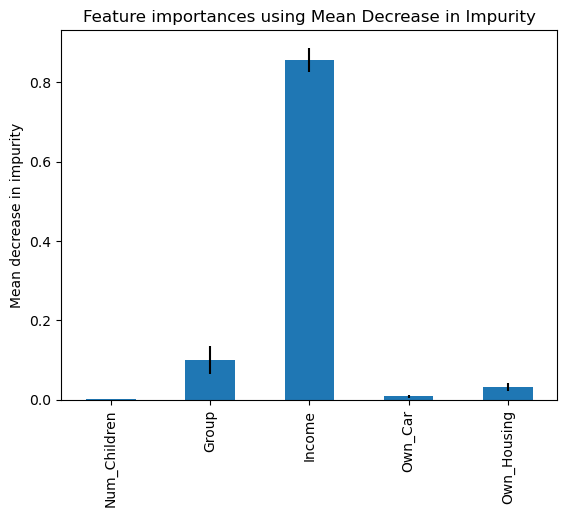

In [8]:
# metrics

train_metrics = get_metrics(y_train, y_train_pred)
test_metrics = get_metrics(y_test, y_test_pred)

fairness_metrics = get_fairness_stats(X_test, y_test, model_baseline, X_test["Group"]==1, y_test_pred)
feature_importances = get_feature_importances(X_train, y_train)


<Figure size 2000x600 with 0 Axes>

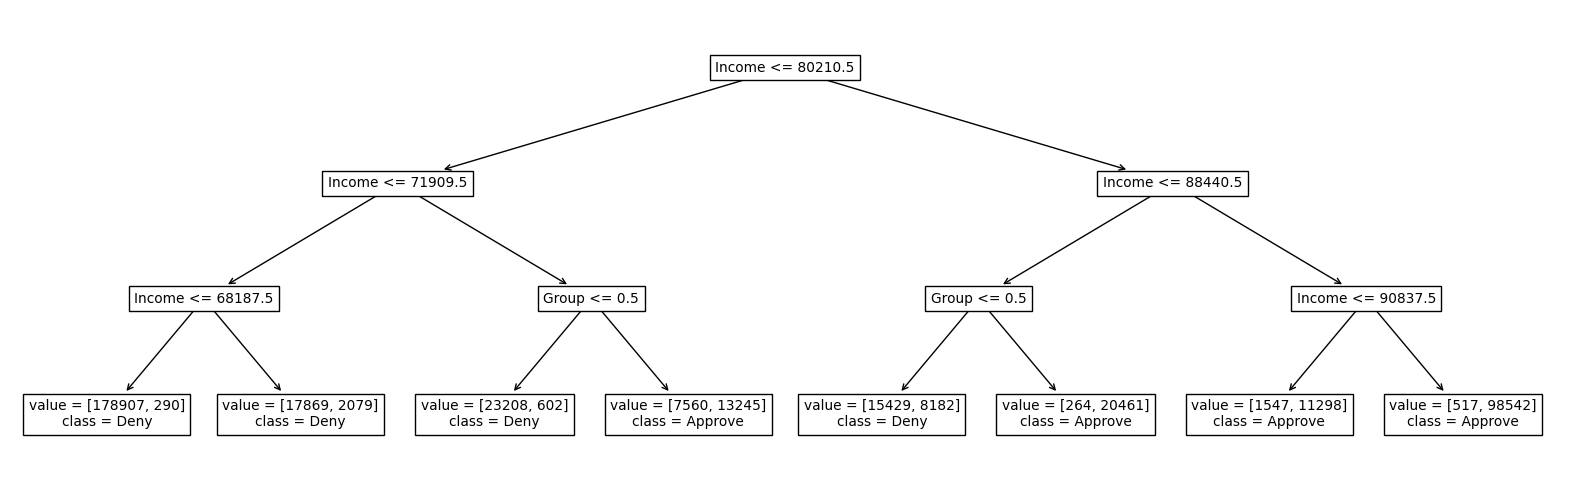

In [9]:


def visualize_model(model, feature_names, class_names=["Deny", "Approve"], impurity=False, filename="model_visualization.jpg"):
    plt.figure(figsize=(20, 6))  # Moved inside the function to ensure a new figure is created for each call
    plot_list = plot_tree(model, feature_names=feature_names, class_names=class_names, impurity=impurity)
    [process_plot_item(item) for item in plot_list]
    plt.savefig(filename,  bbox_inches='tight')  # Save the plot as a JPEG file

def process_plot_item(item):
    split_string = item.get_text().split("\n")
    if split_string[0].startswith("samples"):
        item.set_text("\n".join(split_string[1:]))  # Show only the class names
    else:
        item.set_text(split_string[0])

# Example of how to call visualize_model
# model_baseline is your trained model and X_train.columns are the feature names

plt.figure(figsize=(20, 6))
plot_list = visualize_model(model_baseline, feature_names=X_train.columns)

In [10]:
# gender unaware model

# remove gender
X_train_unaware = X_train.drop(["Group"],axis=1)
X_test_unaware = X_test.drop(["Group"],axis=1)

# train
model_unaware = DecisionTreeClassifier(random_state=0, max_depth=3)
model_unaware.fit(X_train_unaware, y_train)

# predict
y_train_unaware_pred = model_unaware.predict(X_train_unaware)
y_test_unaware_pred = model_unaware.predict(X_test_unaware)

In [11]:
# prediction example
# model_unaware.predict(X_train_unaware.iloc[0:1].values).tolist()[0]

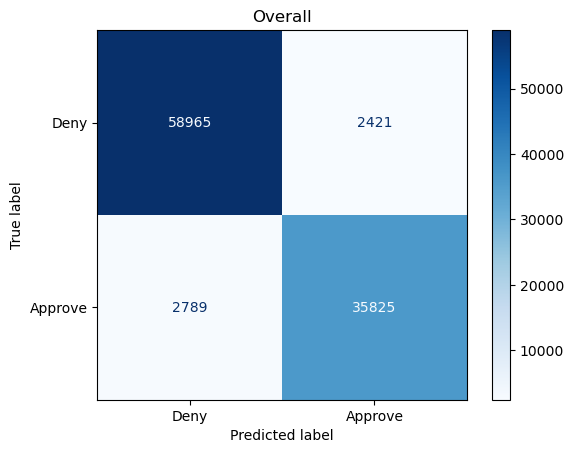

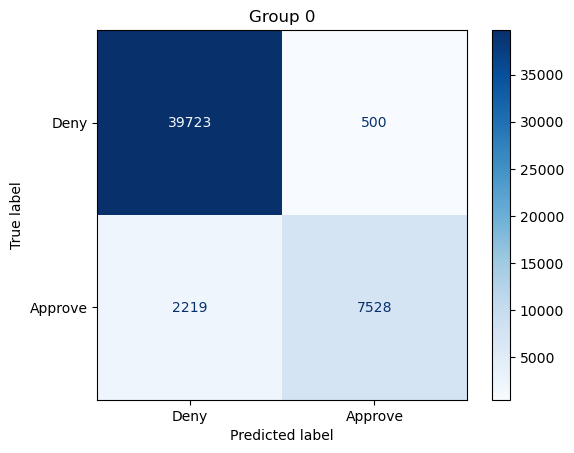

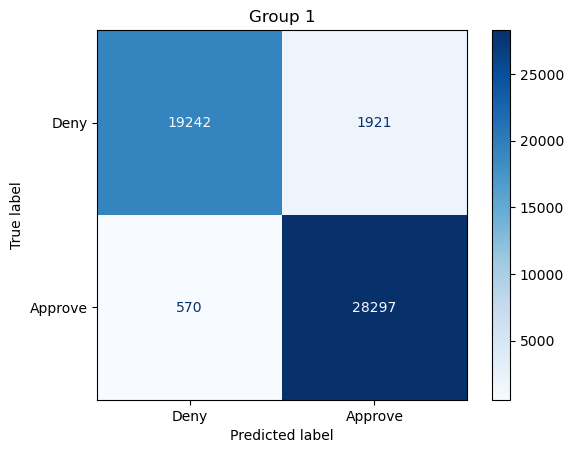

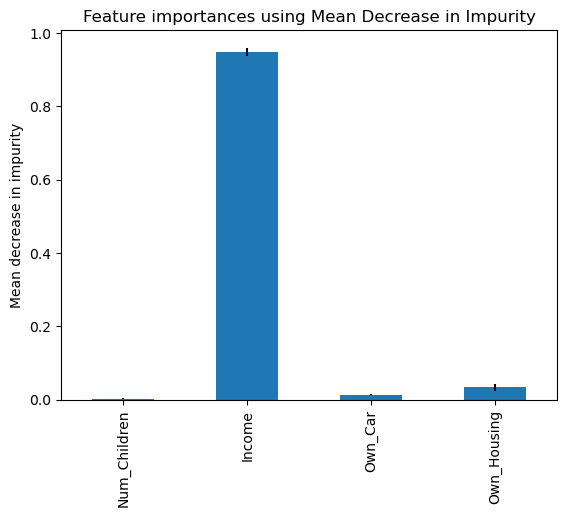

In [12]:
# metrics

train_metrics = get_metrics(y_train, y_train_unaware_pred)
test_metrics = get_metrics(y_test, y_test_unaware_pred)

fairness_metrics = get_fairness_stats(X_test, y_test, model_unaware, X_test["Group"]==1, y_test_pred)

feature_importances = get_feature_importances(X_train_unaware, y_train)

<Figure size 2000x600 with 0 Axes>

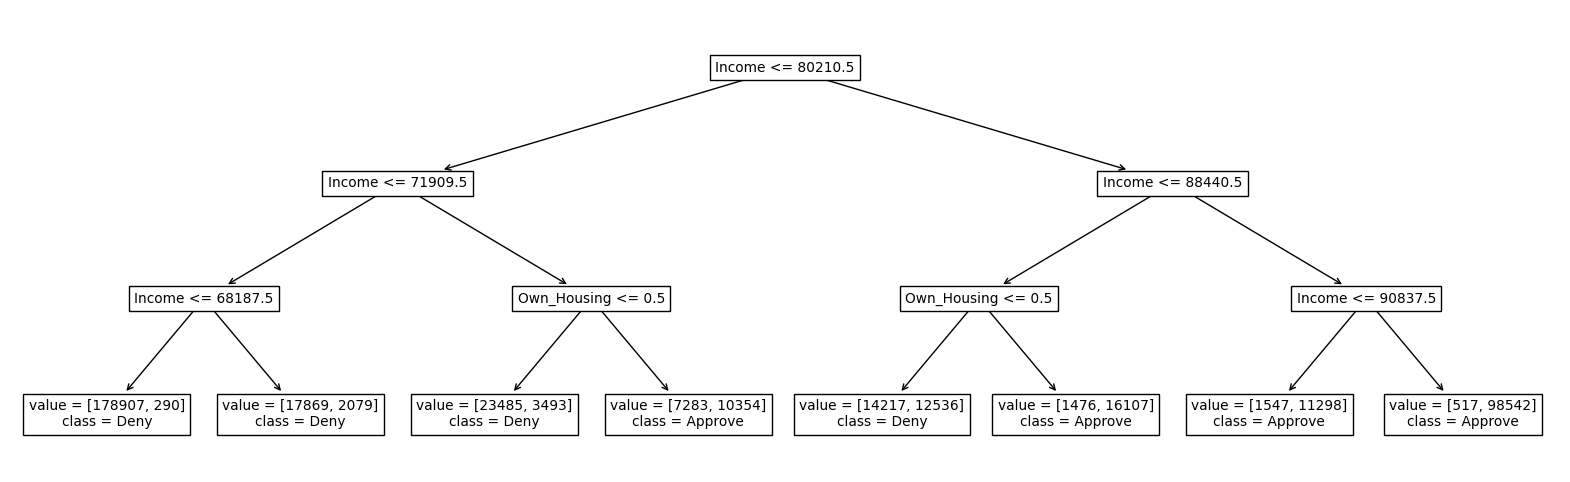

In [13]:
plt.figure(figsize=(20, 6))
plot_list = visualize_model(model_unaware, feature_names=X_train_unaware.columns)

{'demographic_parity': {'total_number_of_approvals': 38241,
  'group_0_%': 51.96,
  'group_1_%': 48.04},
 'equal_opportunity': {'true_positive_rate': 72.82,
  'group_0_%': 100.0,
  'group_1_%': 63.64},
 'equal_accuracy': {'overall_accuracy': 79.38,
  'group_0_%': 79.74,
  'group_1_%': 79.02},
 'confusion_matrix': {'overall_confusion_matrix': [[51264, 10122],
   [10495, 28119]],
  'group_0': [[30101, 10122], [0, 9747]],
  'group_1': [[21163, 0], [10495, 18372]]}}

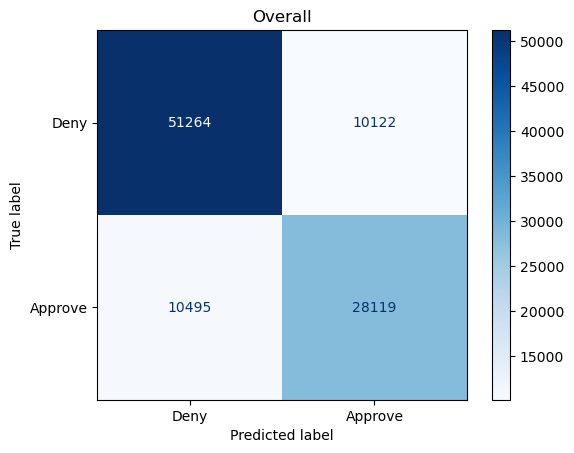

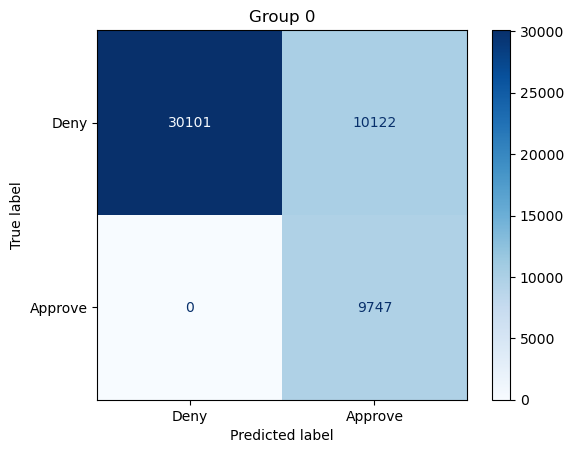

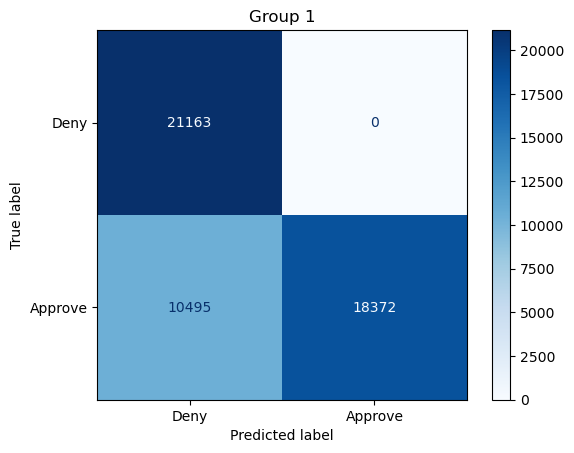

In [14]:
# threshold finetuning to further mitigate bias

zero_threshold = 0.11
one_threshold = 0.99

# predict
test_probs = model_unaware.predict_proba(X_test_unaware)[:,1]
preds_approval = (((test_probs>zero_threshold)*1)*[X_test["Group"]==0] + ((test_probs>one_threshold)*1)*[X_test["Group"]==1])[0]
get_fairness_stats(X_test, y_test, model_unaware, X_test["Group"]==1, preds_approval)

# save 

In [15]:
feature_importances

'{"Num_Children":0.0030877149,"Income":0.9491235114,"Own_Car":0.0143102116,"Own_Housing":0.033478562}'

In [16]:
# save selected model and metrics
selected_model = model_unaware
selected_model_metrics = {'train': train_metrics,
                          'test': test_metrics,
                          'fairness': fairness_metrics,
                          'feature_importances': feature_importances}

joblib.dump(selected_model, selected_model_file_path)
joblib.dump(selected_model_metrics, selected_model_metrics_file_path)

['selected_model_metrics.joblib']

In [17]:
# Write the dictionary to a file in JSON format
class NumpyEncoder(json.JSONEncoder):
    """ Custom encoder for numpy data types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NumpyEncoder, self).default(obj)

with open(selected_model_metrics_file_path.replace('joblib','json'), 'w') as file:
    json.dump(selected_model_metrics, file,  cls=NumpyEncoder, indent=4)

# track

In [18]:
# track experiment 
mlflow.set_experiment(experiment_name)
mlflow.start_run(run_name=run_name)

mlflow.log_params(
    {
        "model_type": model_name,
        "n_features": X.shape[1],
        "feature_importances": feature_importances
    }
)

mlflow.log_metric('train_f1', selected_model_metrics['train']['f1'])
mlflow.log_metric('test_f1', selected_model_metrics['test']['f1'])
   
mlflow.log_artifact(f"{selected_model_file_path}")

mlflow.end_run()

# test

In [19]:
# NBVAL_CHECK_OUTPUT
selected_model_metrics = joblib.load(selected_model_metrics_file_path)

In [20]:
# NBVAL_CHECK_OUTPUT
# model accuracy
threshold_accuracy = 0.9
accuracy = selected_model_metrics['test']['accuracy']
assert accuracy > threshold_accuracy, 'accuracy {} is below {}'.format(accuracy, threshold_accuracy)

In [21]:
# NBVAL_CHECK_OUTPUT
# fairness
equal_opportunity_fairness_threshold_percent = 21
equal_opportunity_group_0_percent = selected_model_metrics['fairness']['equal_opportunity']['group_0_%']
equal_opportunity_group_1_percent = selected_model_metrics['fairness']['equal_opportunity']['group_1_%']
assert abs(equal_opportunity_group_0_percent - equal_opportunity_group_1_percent) < equal_opportunity_fairness_threshold_percent, 'difference exceeds {}%'.format(equal_opportunity_fairness_threshold_percent)

In [22]:
data = selected_model_metrics

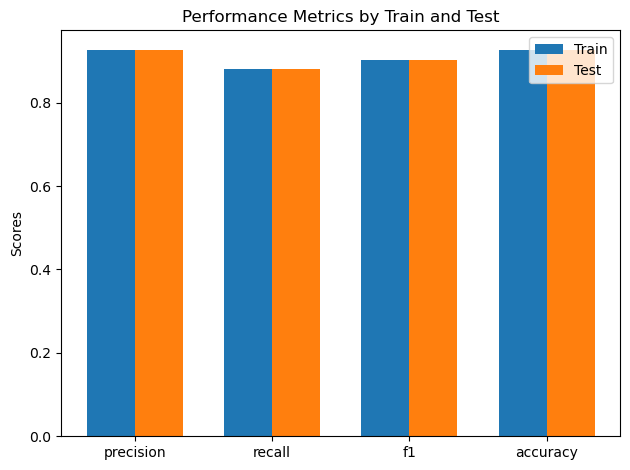

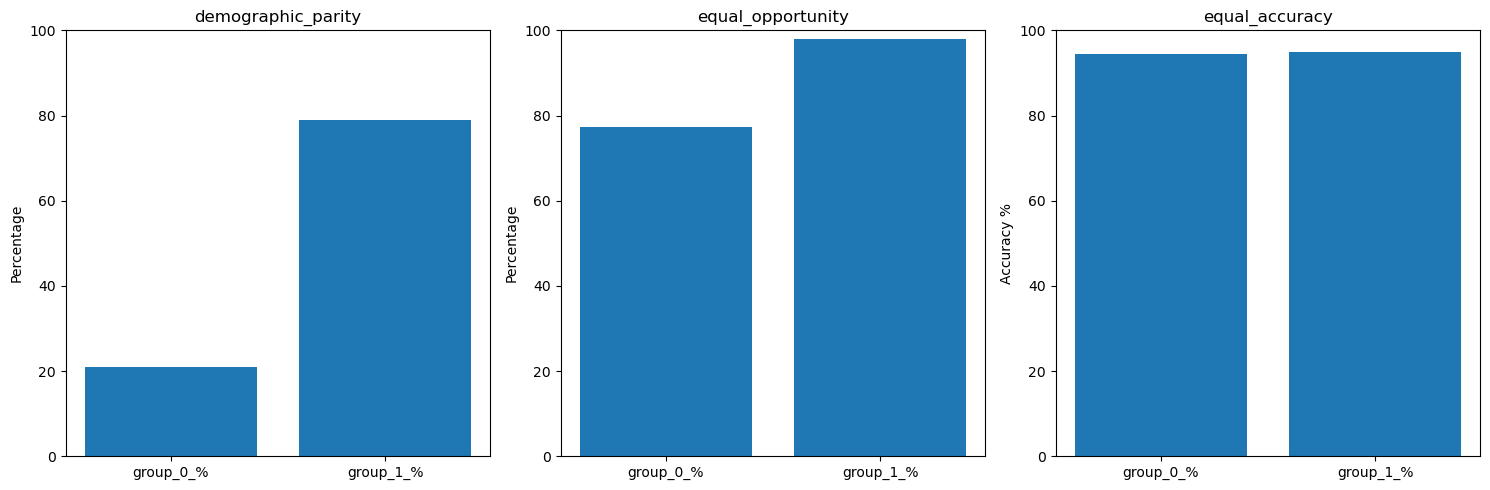

In [23]:
# Performance Metrics Visualization
performance_metrics = ['precision', 'recall', 'f1', 'accuracy']
train_performance = [data['train'][metric] for metric in performance_metrics]
test_performance = [data['test'][metric] for metric in performance_metrics]

ind = np.arange(len(performance_metrics))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, train_performance, width, label='Train')
rects2 = ax.bar(ind + width/2, test_performance, width, label='Test')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics by Train and Test')
ax.set_xticks(ind)
ax.set_xticklabels(performance_metrics)
ax.legend()

fig.tight_layout()
plt.savefig("Performance Metrics by Train and Test.jpg",  bbox_inches='tight')  # Save plot as JPEG file

plt.show()

# Fairness Metrics Visualization - Demographic Parity and Equal Opportunity
fairness_metrics = ['demographic_parity', 'equal_opportunity', 'equal_accuracy']
groups = ['group_0_%', 'group_1_%']
fairness_values = {metric: [data['fairness'][metric][group] for group in groups] for metric in fairness_metrics}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, (metric, values) in zip(axs, fairness_values.items()):
    ax.bar(groups, values)
    ax.set_title(metric)
    ax.set_ylabel('Percentage' if metric != 'equal_accuracy' else 'Accuracy %')
    ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig("Fairness Metrics Visualization - Demographic Parity and Equal Opportunity.jpg",  bbox_inches='tight')  # Save plot as JPEG file

plt.show()


## Save in one markdown

In [24]:
!ls *.jpg

Fairness Metrics Visualization - Demographic Parity and Equal Opportunity.jpg
Performance Metrics by Train and Test.jpg
feature_importances.jpg
group_0_confusion_matrix.jpg
group_1_confusion_matrix.jpg
model_visualization.jpg
overall_confusion_matrix.jpg


In [25]:


image_filenames = [
    'Performance Metrics by Train and Test.jpg',
    'feature_importances.jpg',
    'model_visualization.jpg',
    'Fairness Metrics Visualization - Demographic Parity and Equal Opportunity.jpg',
    'overall_confusion_matrix.jpg'
]

descriptions = [
    "Performance Metrics by Train and Test",
    "Feature Importances",
    "Model Visualization",
    "Fairness Metrics Visualization - Demographic Parity and Equal Opportunity",
    "Overall Confusion Matrix"
]

output_filename = 'Output.html'  # Adjust the path as necessary



In [26]:


def images_to_base64_html(image_filenames, descriptions, output_filename='combined_images.html'):
    """
    Embeds a list of images in JPEG format into an HTML file using Base64 encoding, with descriptions as headings.
    
    Parameters:
    - image_filenames: List[str]. A list of paths to the image files.
    - descriptions: List[str]. A list of descriptions for the images.
    - output_filename: str. The name of the output HTML file.
    """
    # Ensure the number of descriptions matches the number of images
    if len(image_filenames) != len(descriptions):
        print("Error: The number of descriptions must match the number of images.")
        return

    # Extract the directory name from the output_filename
    output_dir = os.path.dirname(output_filename)
    
    # Ensure the output directory exists, if a directory path is provided
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    
    # Start writing to the HTML file
    with open(output_filename, 'w') as html_file:
        html_file.write("<html>\n<head>\n<title>All Plots</title>\n</head>\n<body>\n")
        for image_filename, description in zip(image_filenames, descriptions):
            # Ensure the file exists and is a JPEG image
            if os.path.exists(image_filename) and (image_filename.lower().endswith('.jpeg') or image_filename.lower().endswith('.jpg')):
                # Encode the image to Base64
                with open(image_filename, 'rb') as image_file:
                    encoded_string = base64.b64encode(image_file.read()).decode()
                    # Write the description as a heading and the image in Base64 format to the HTML file
                    html_file.write(f"<h1>{description}</h1>\n<img src='data:image/jpeg;base64,{encoded_string}' />\n")
            else:
                print(f"File does not exist or is not a JPEG image: {image_filename}")
        html_file.write("</body>\n</html>")



# Make sure the path exists or is adjusted according to your environment before running the function
images_to_base64_html(image_filenames, descriptions, output_filename)


## mlflow tracking

In [27]:
MLFLOW_TRACKING_URI = "http://ec2-3-144-250-80.us-east-2.compute.amazonaws.com:5000"

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

mlflow.set_experiment(experiment_name)
mlflow.start_run(run_name=run_name)

#if os.getenv('GITLAB_CI'):
#    mlflow.set_tag('gitlab.CI_JOB_ID', os.getenv('CI_JOB_ID'))
# HARNESS_PIPELINE_ID = os.env(HARNESS_PIPELINE_ID)

#if os.getenv('HARNESS_CI'):
mlflow.set_tag('HARNESS_PIPELINE_ID', os.getenv('HARNESS_PIPELINE_ID'))

mlflow.log_params({
    "model_type": model_name,
    "n_features": X.shape[1],
    "feature_importances": feature_importances
})

performance_metrics = ['precision', 'recall', 'f1', 'accuracy']
for metric in performance_metrics:
    mlflow.log_metric('train_'+metric, selected_model_metrics['train'][metric])
    mlflow.log_metric('test_'+metric, selected_model_metrics['test'][metric])
                        
mlflow.log_artifact(f"{selected_model_file_path}")
for ifile in image_filenames:
    mlflow.log_artifact(ifile)

mlflow.end_run()


2024/03/04 12:23:18 INFO mlflow.tracking.fluent: Experiment with name 'Example MLOps' does not exist. Creating a new experiment.
